In [1]:
import json, os, random, math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

plt.rcParams["figure.figsize"] = (6, 6)
print("numpy:", np.__version__)

numpy: 2.2.6


In [16]:
# Build a tiny COCO-style dataset (1 image, 2 categories)
root = Path("mini_coco")
img_dir = root / "images"
ann_dir = root / "annotations"
img_dir.mkdir(parents=True, exist_ok=True)
ann_dir.mkdir(parents=True, exist_ok=True)

# Image: 256x256 with a polygon "person" and rectangular "car"
W, H = 256, 256
img = Image.new("RGB", (W, H), (240, 240, 240))
dr = ImageDraw.Draw(img)

# A rough humanoid polygon (for "person")
poly = [(120,30),(135,60),(150,60),(150,100),(165,120),(165,160),
        (150,200),(120,200),(105,160),(105,120),(120,100),(120,60)]
dr.polygon(poly, fill=(200,130,130))

# A rectangle (for "car")
car_bbox = (40, 170, 120, 210)  # (x0,y0,x1,y1)
dr.rectangle(car_bbox, fill=(130,160,200))

img_id = 1
img_name = "000000000001.jpg"
img.save(img_dir / img_name)

# COCO-style dicts
images = [{"id": img_id, "file_name": img_name, "width": W, "height": H}]
categories = [
    {"id": 1, "name": "person", "supercategory": "person"},
    {"id": 3, "name": "car", "supercategory": "vehicle"},
]

# polygon -> flat list [x1,y1,x2,y2,...]
poly_flat = [v for xy in poly for v in xy]

# Build binary mask for car and encode as RLE
mask = np.zeros((H, W), dtype=np.uint8)
x0, y0, x1, y1 = car_bbox
mask[y0:y1, x0:x1] = 1
rle_car = maskUtils.encode(np.asfortranarray(mask))
rle_car["counts"] = rle_car["counts"].decode("ascii")  # JSON serializable


annotations = [
    {
        "id": 1,
        "image_id": img_id,
        "category_id": 1,             # person
        "bbox": [105, 30, 60, 170],   # [x,y,w,h], NOT xyxy
        "area": 60*170,
        "iscrowd": 0,
        "segmentation": [poly_flat],  # polygon segmentation
    },
    {
        "id": 2,
        "image_id": img_id,
        "category_id": 3,             # car
        "bbox": [40, 170, 80, 40],    # xywh
        "area": int(maskUtils.area(rle_car).item()),
        "iscrowd": 0,
        "segmentation": rle_car,      # RLE segmentation
    },
]

info = {
    "description": "mini COCO tutorial dataset",
    "url": "",
    "version": "1.0",
    "year": 2025,
    "contributor": "",
    "date_created": "2025-08-19"
}
licenses = []  # optional, can be empty

coco_data = {
    "info": info,
    "licenses": licenses,
    "images": images,
    "annotations": annotations,
    "categories": categories
}

ann_path = ann_dir / "instances_val2017.json"
with open(ann_path, "w") as f:
    json.dump(coco_data, f)

print("Wrote synthetic dataset to:", root.resolve())

Wrote synthetic dataset to: /BS/generative_modelling_for_image_understanding/work/my_projects/github_repos/cvml_engineering_gym/understanding_coco2017/mini_coco


In [18]:
coco = COCO(str(ann_path))

# Categories
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
print("Categories:", [c["name"] for c in cats])

# Images that contain any of these categories
img_ids = coco.getImgIds(catIds=cat_ids)
print("Image IDs:", img_ids)

img_info = coco.loadImgs(img_ids[0])[0]
img_info

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Categories: ['person', 'car']
Image IDs: [1]


{'id': 1, 'file_name': '000000000001.jpg', 'width': 256, 'height': 256}

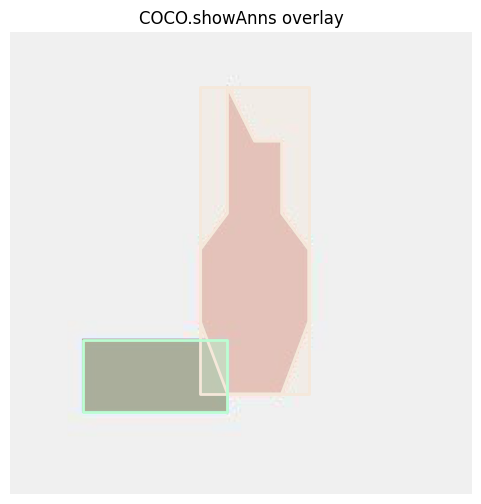

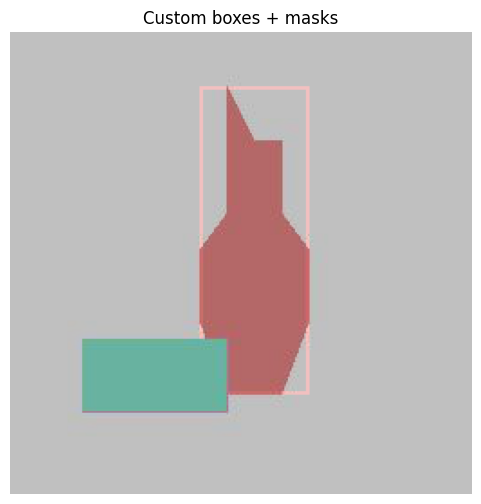

In [19]:
img_path = img_dir / img_info["file_name"]
I = np.array(Image.open(img_path))

ann_ids = coco.getAnnIds(imgIds=img_info["id"], iscrowd=None)
anns = coco.loadAnns(ann_ids)

# Quick overlay using COCO.showAnns
plt.imshow(I); plt.axis("off")
coco.showAnns(anns, draw_bbox=True)
plt.title("COCO.showAnns overlay")
plt.show()

# Custom renderer: draw boxes + masks
def draw_boxes_and_masks(I, anns, alpha=0.4):
    plt.imshow(I); plt.axis("off")
    overlay = Image.fromarray(np.zeros_like(I), mode="RGB")
    dr = ImageDraw.Draw(overlay, "RGBA")

    for a in anns:
        x, y, w, h = a["bbox"]
        dr.rectangle([x, y, x+w, y+h], outline=(255,0,0,255), width=2)

        # Draw segmentation (polygon or RLE)
        if isinstance(a["segmentation"], list):
            for seg in a["segmentation"]:
                poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                dr.polygon(poly, fill=(255,0,0,int(255*alpha)))
        else:
            # RLE → binary mask → paint pixels
            m = maskUtils.decode(a["segmentation"])
            ys, xs = np.where(m > 0)
            for (yy, xx) in zip(ys, xs):
                overlay.putpixel((int(xx), int(yy)), (0,255,0,int(255*alpha)))

    plt.imshow(overlay, alpha=0.2)
    plt.title("Custom boxes + masks")
    plt.show()

draw_boxes_and_masks(I, anns)


In [20]:
# Mask utilities: polygons↔RLE, area, IoU, bbox-from-mask
# Split person (polygon segm) and car (RLE segm)
ann_person = [a for a in anns if a["category_id"] == 1][0]
ann_car    = [a for a in anns if a["category_id"] == 3][0]

H, W = img_info["height"], img_info["width"]

# polygon → (possibly multiple) RLEs → merged RLE
rles_person = maskUtils.frPyObjects(ann_person["segmentation"], H, W)
rle_person  = maskUtils.merge(rles_person)

area_person = maskUtils.area(rle_person).item()
area_car    = maskUtils.area(ann_car["segmentation"]).item()
print("Areas — person:", area_person, "car:", area_car)

# IoU between person mask and car mask
iou = maskUtils.iou([rle_person], [ann_car["segmentation"]], [0])  # [gt_iscrowd]
print("IoU(person vs car):", iou)

# Get xywh bbox directly from a mask
bbox_from_mask = maskUtils.toBbox(rle_person)
print("BBox from person mask (xywh):", bbox_from_mask)


Areas — person: 6525 car: 3200
IoU(person vs car): [[0.01768522]]
BBox from person mask (xywh): [105.  31.  60. 169.]


In [21]:
# Evaluate predictions with COCOeval (bbox & segm)
# Build toy predictions (match GT for demo)
preds = [
    {
        "image_id": img_id,
        "category_id": 1,
        "bbox": [105, 30, 60, 170],
        "score": 0.95,
        "segmentation": ann_person["segmentation"],
    },
    {
        "image_id": img_id,
        "category_id": 3,
        "bbox": [40, 170, 80, 40],
        "score": 0.90,
        "segmentation": ann_car["segmentation"],
    },
]

res_path = root / "results.json"
with open(res_path, "w") as f:
    json.dump(preds, f)
print("Wrote predictions:", res_path)

cocoGt = coco
cocoDt = cocoGt.loadRes(str(res_path))

# bbox metrics
e_bbox = COCOeval(cocoGt, cocoDt, iouType="bbox")
e_bbox.params.imgIds = [img_id]      # subset evaluation
e_bbox.evaluate(); e_bbox.accumulate(); e_bbox.summarize()

# segm metrics
e_segm = COCOeval(cocoGt, cocoDt, iouType="segm")
e_segm.params.imgIds = [img_id]
e_segm.evaluate(); e_segm.accumulate(); e_segm.summarize()


Wrote predictions: mini_coco/results.json
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Recall     (AR) 

In [22]:
# (Bonus) Keypoints & OKS mini demo
# Minimal keypoints GT + prediction for the same image
kp_ann_path = ann_dir / "person_keypoints_val2017.json"

def kp(x, y, v=2):   # v: 0 not labeled, 1 labeled-not-visible, 2 visible
    return [x, y, v]

# 17 keypoints required by COCO; we fill 5 and mark the rest as not labeled
kps = kp(130,50)+kp(130,80)+kp(130,110)+kp(115,140)+kp(145,140)  # toy points
while len(kps) < 17*3:
    kps += [0,0,0]

kp_anns = [{
    "id": 101,
    "image_id": img_id,
    "category_id": 1,
    "keypoints": kps,
    "num_keypoints": 5,
    "bbox": [105, 30, 60, 170],
    "area": 60*170,
    "iscrowd": 0
}]
kp_cats = [{
    "id": 1, "name": "person", "supercategory": "person",
    "keypoints": [
        "nose","left_eye","right_eye","left_ear","right_ear",
        "left_shoulder","right_shoulder","left_elbow","right_elbow",
        "left_wrist","right_wrist","left_hip","right_hip",
        "left_knee","right_knee","left_ankle","right_ankle"
    ],
    "skeleton": []
}]

kp_data = {
    "info": info,
    "licenses": licenses,
    "images": images,
    "annotations": kp_anns,
    "categories": kp_cats
}
with open(kp_ann_path, "w") as f:
    json.dump(kp_data, f)

# Matching prediction
kp_pred = [{
    "image_id": img_id,
    "category_id": 1,
    "keypoints": kps,
    "score": 0.98
}]
kp_res_path = root / "results_keypoints.json"
with open(kp_res_path, "w") as f:
    json.dump(kp_pred, f)

cocoGt_kp = COCO(str(kp_ann_path))
cocoDt_kp = cocoGt_kp.loadRes(str(kp_res_path))
e_kp = COCOeval(cocoGt_kp, cocoDt_kp, iouType="keypoints")
e_kp.params.imgIds = [img_id]
e_kp.evaluate(); e_kp.accumulate(); e_kp.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m